In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import arviz as az
np.seterr(under='ignore') # This is for bambi to work

import bambi as bmb
import kulprit as kpt

/home/lucabol/miniconda3/envs/bap3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ms = pd.read_csv('~/dev/divs/msr.csv')
sds = pd.read_csv('~/dev/divs/sdsr.csv')

# Full outer join the two datasets
df = pd.merge(ms, sds, how='outer', left_on='Tik', right_on='TikS')

# Create a new column 'Ticker' that is equal to 'Tik' if 'Tik' is not null, and 'TikS' otherwise and make it the index
df['Ticker'] = df['Tik'].combine_first(df['TikS'])
df = df.set_index('Ticker')

# Make the 'Yld' column always have value by using 'Yld' if it is not null, and 'YldS' otherwise, 'YldB' otherwise
df['Yld'] = df['Yld'].combine_first(df['YldS'])
df['Yld'] = df['Yld'].combine_first(df['YldB'])

# Change column 'Name' so that it is equal to 'Name' if 'Name' is not null, and 'NameS' otherwise
df['Name'] = df['Name'].combine_first(df['NameS'])

df['Yld'] = pd.to_numeric(df['Yld'], errors='coerce')

cols = ['Saf', 'Pay', 'Tax', 'Sector', 'U']

df = df[['Yld'] + cols]

df['Saf'] = df['Saf'].replace(np.nan, df['Saf'].median())
df['Pay'] = df['Pay'].replace(np.nan, df['Pay'].median())

df['U'] = df['U'].replace(np.nan, 'Medium')
df['Tax'] = df['Tax'].replace(np.nan, 'Qualified')
df['Sector'] = df['Sector'].replace(np.nan, 'Unknown')

# sv_report = sv.analyze(df)
# sv_report.show_html('report.html')

In [3]:
formula = 'Yld ~ ' + ' + '.join(cols)
print(formula)

model = bmb.Model(formula, data = df, dropna=True)
model
#model.build()
#model.plot_priors()

Automatically removing 1/263 rows from the dataset.


Yld ~ Saf + Pay + Tax + Sector + U


       Formula: Yld ~ Saf + Pay + Tax + Sector + U
        Family: gaussian
          Link: mu = identity
  Observations: 262
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 5.1607, sigma: 25.6396)
            Saf ~ Normal(mu: 0.0, sigma: 0.2934)
            Pay ~ Normal(mu: 0.0, sigma: 0.062)
            Tax ~ Normal(mu: [0. 0. 0. 0.], sigma: [27.8028 21.889  94.2602 14.469 ])
            Sector ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma: [19.4404 18.2534 14.906  22.4114
                22.4114 31.913  21.889  26.7656 13.9997])
            U ~ Normal(mu: [0. 0. 0.], sigma: [18.5256 14.7909 42.4812])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.3249)

In [12]:
idata = model.fit(idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Yld_sigma, Intercept, Saf, Pay, Tax, Sector, U]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


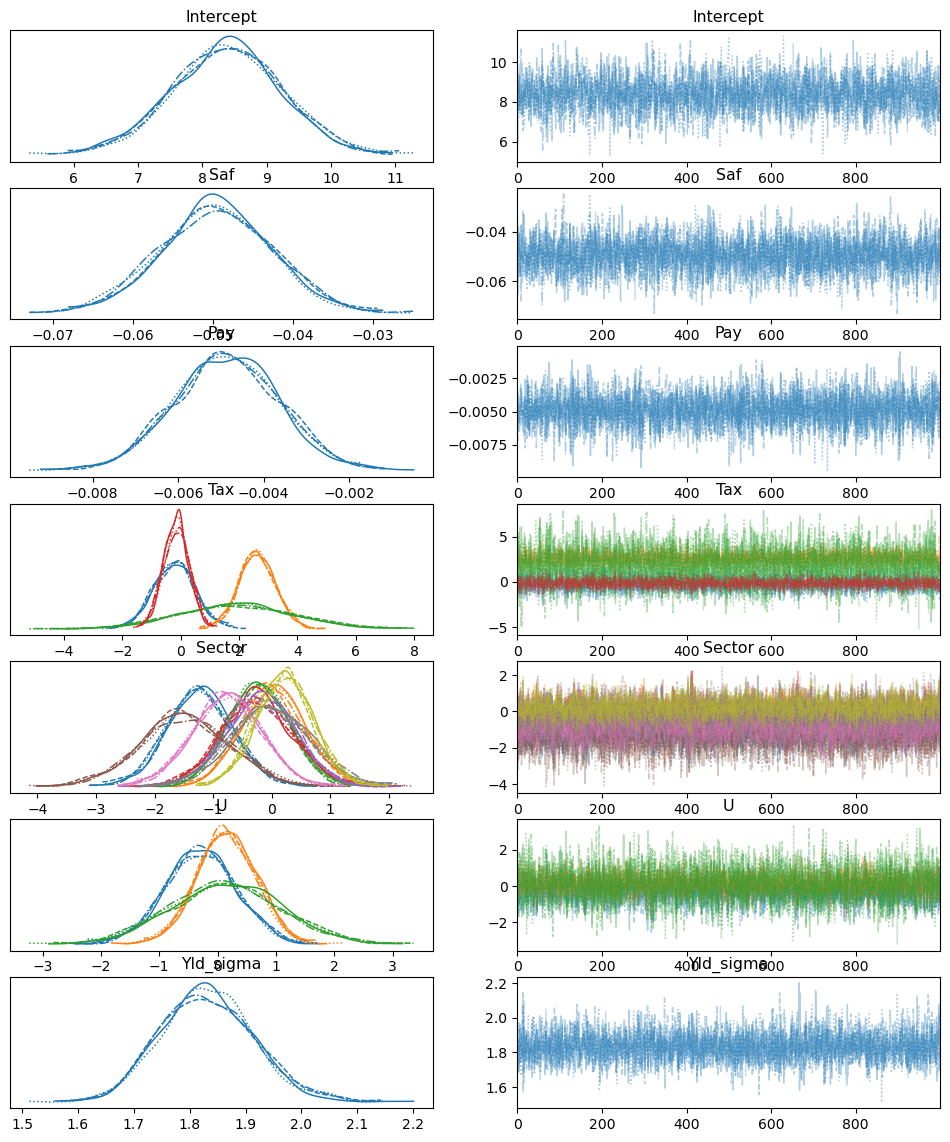

In [13]:
_ = az.plot_trace(idata)

In [10]:
#idata.to_netcdf("kptidata1.nc")
#idata = az.from_netcdf("kptidata1.nc")
ppi = kpt.ProjectionPredictive(model, idata)
ppi.search()

UserWarning: Please run Bambi's fit method with the option
                idata_kwargs={'log_likelihood': True}

/home/lucabol/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/lucabol/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/lucabol/miniconda3/envs/bap3/lib/p

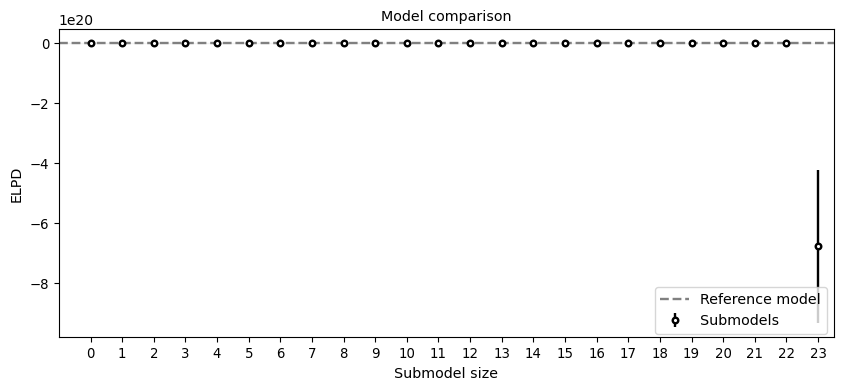

In [38]:
cmp, ax = ppi.plot_compare(plot=True, figsize=(10, 4));